In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import requests as req
import json

from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

new_path = os.getcwd().replace('/notebooks', '')
print(f'Adding {new_path} to sys.path')

if new_path not in sys.path:
    sys.path.append(new_path)

# Local imports
from curvemetrics.src.classes.datahandler import DataHandler
from curvemetrics.src.classes.datafetcher import DataFetcher
from curvemetrics.src.classes.metricsprocessor import MetricsProcessor
from curvemetrics.src.detection.bocd import bocd
from curvemetrics.src.plotting.plot import bocd_plot_dm, bocd_plot, bocd_plot_comp
from curvemetrics.src.detection.scorer import true_positives, f_measure

Adding /root/curve-lp-metrics to sys.path
Use scipy logsumexp().


In [3]:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 10})

In [4]:
datahandler = DataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()

pool = "0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7" # 3pool

start_ts, start_block = DataFetcher.get_block(datetime.fromisoformat("2023-02-01"))
end_ts, end_block = DataFetcher.get_block(datetime.fromisoformat("2023-04-01"))

In [5]:
swaps_data = datahandler.get_swaps_data(pool, start_ts, end_ts)
lp_data = datahandler.get_lp_data(pool, start_ts, end_ts)
pool_data = datahandler.get_pool_data(pool, start_ts, end_ts)
tokens = {token_metadata[v]['symbol']:v for v in set(swaps_data['tokenBought'])}
ohlcvs = {}
for k, v in tokens.items():
    if k == "3Crv":
        continue
    ohlcv = datahandler.get_ohlcv_data(v, start=start_ts, end=end_ts)
    ohlcvs[v] = ohlcv

In [8]:
metricsprocessor = MetricsProcessor(pool_metadata, token_metadata, freq='1min')
pool_metrics = metricsprocessor.process_metrics_for_pool(pool, pool_data, swaps_data, lp_data, ohlcvs)
lp_share_price = metricsprocessor.lp_share_price(pool, pool_data, ohlcvs)

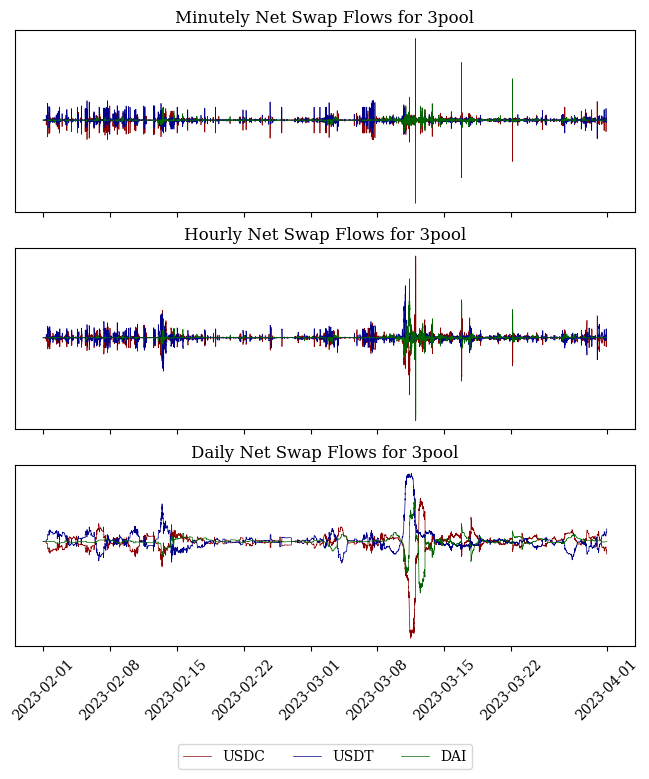

In [9]:
f, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

titles = ['Minutely', 'Hourly', 'Daily']
freqs = ['1min', '1h', '1d']

for i, ax in enumerate(axs):

    usdc_flow = pool_metrics['USDC.netSwapFlow'].rolling(freqs[i]).sum() / 1e6
    usdt_flow = pool_metrics['USDT.netSwapFlow'].rolling(freqs[i]).sum() / 1e6
    dai_flow = pool_metrics['DAI.netSwapFlow'].rolling(freqs[i]).sum() / 1e6

    ax.plot(usdc_flow.index, usdc_flow, label='USDC', linewidth=0.5, c='darkred')
    ax.plot(usdt_flow.index, usdt_flow, label='USDT', linewidth=0.5, c='darkblue')
    ax.plot(dai_flow.index, dai_flow, label='DAI', linewidth=0.5, c='darkgreen')

    # ax.grid(True)
    ax.set_title(f'{titles[i]} Net Swap Flows for 3pool')
    ax.set_yticks([])
    
ax.tick_params(axis='x', rotation=45)
axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=3)
f.savefig('../figs/3pool_swap_flows.png', bbox_inches='tight')

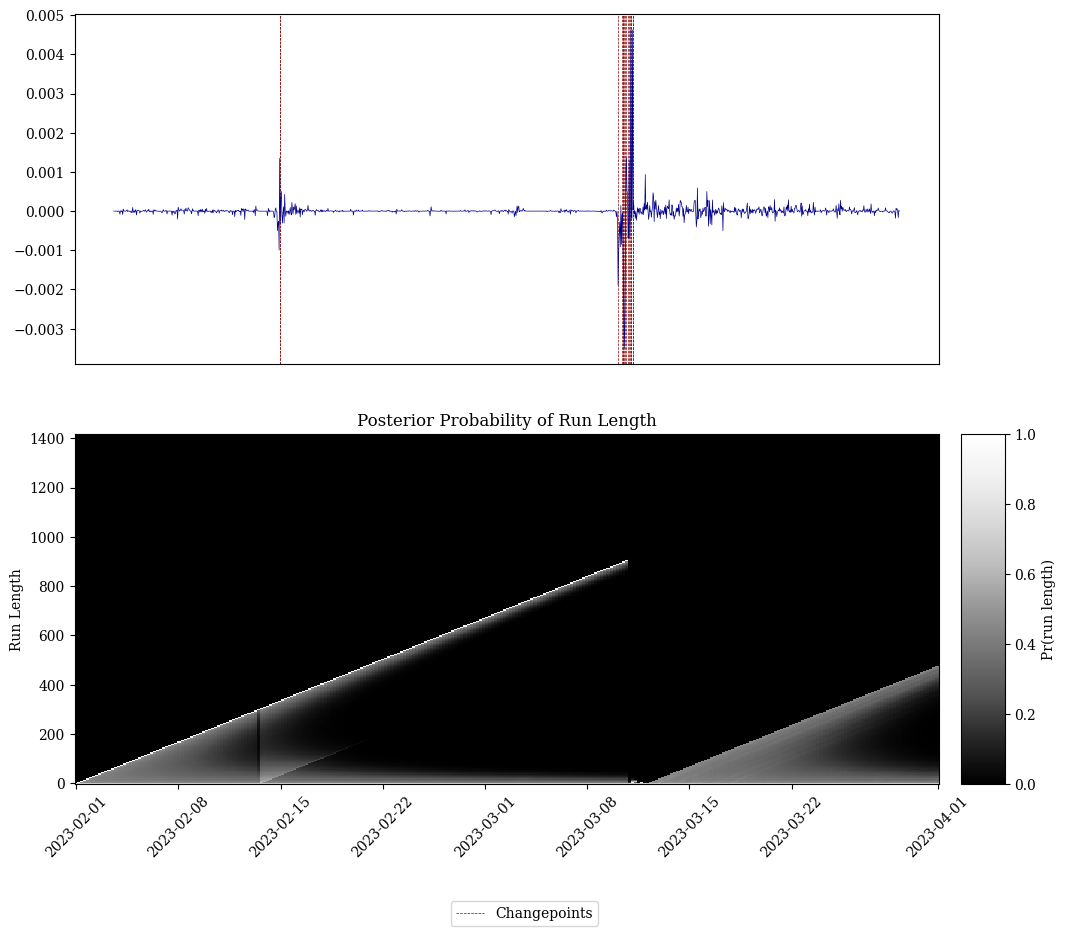

In [10]:
freq = '1h'
metric = np.log1p(pool_metrics['shannonsEntropy'].pct_change()).resample(freq).mean()
R, maxes = bocd(metric[:-1], alpha=1000, beta=0.0001, kappa=0.001)
peaks = np.where(maxes[:-1]!=maxes[1:]-1)[0]
bocd_plot_dm(metric, maxes, R, show=True)

In [11]:
async def get_snapshots():
    datafetcher = DataFetcher(token_metadata=token_metadata)
    try:
        snapshots = datafetcher.get_snapshots(start_ts, end_ts, pool)
    except Exception as e:
        print(f'excepted: {e}')
        return 
    finally:
        await datafetcher.close()
    return snapshots
    
snapshots = await get_snapshots()

[autoreload of curvemetrics.src.classes.datahandler failed: Traceback (most recent call last):
  File "/root/curve-lp-metrics/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/root/curve-lp-metrics/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/root/curve-lp-metrics/curvemetrics/src/classes/datahandler.py", line 337
    @staticmethod
    ^
IndentationErr

In [14]:
snapshots = DataHandler.format_pool_snapshots(snapshots)
snapshots = snapshots.sort_values(by='timestamp')
snapshots.index = snapshots['timestamp'].apply(datetime.fromtimestamp)
snapshots.head()

,A,adminFee,fee,id,normalizedReserves,offPegFeeMultiplier,reserves,timestamp,virtualPrice,lpPriceUSD,tvl,totalDailyFeesUSD,reservesUSD,lpFeesUSD,lastPricesTimestamp,lastPrices,pool_id,block_gte,block_lt
timestamp,,,,,,,,,,,,,,,,,,,
2023-02-02,2000,0.0,0.0001,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7-167...,"[195929319637713056513345179, 2104826655191090...",0,"[195929319637713056513345179, 210482665519109,...",1675296000,1023646103653779893,1.023570,5.599598e+08,0.0,"[195914033.88529265, 210453959.1297073, 153591...",0.0,0,0,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,1675209611,1675296011
2023-02-03,2000,0.0,0.0001,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7-167...,"[198379736118983352980383469, 2139165865100450...",0,"[198379736118983352980383469, 213916586510045,...",1675382400,1023655776558950661,1.023587,5.556716e+08,0.0,"[198364662.14648715, 213890009.92703095, 14341...",0.0,0,0,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,1675296011,1675382411
2023-02-04,2000,0.0,0.0001,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7-167...,"[200757940514131535581363733, 2167750326434000...",0,"[200757940514131535581363733, 216775032643400,...",1675468800,1023668380588376357,1.023589,5.615920e+08,0.0,"[200739606.34999707, 216745615.3644543, 144106...",0.0,0,0,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,1675382411,1675468811
2023-02-05,2000,0.0,0.0001,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7-167...,"[201034878108928476393725136, 2087071843432090...",0,"[201034878108928476393725136, 208707184343209,...",1675555200,1023674499417143695,1.023605,5.587678e+08,0.0,"[201019382.2785989, 208681563.938929, 14906680...",0.0,0,0,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,1675468811,1675555211
2023-02-06,2000,0.0,0.0001,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7-167...,"[203771951949236403699812494, 2312672592459060...",0,"[203771951949236403699812494, 231267259245906,...",1675641600,1023687116121716870,1.023626,5.561821e+08,0.0,"[203764220.3719749, 231231089.27394173, 121186...",0.0,0,0,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,1675555211,1675641611


In [21]:
cps, error, vp, rp = metricsprocessor.true_cps(lp_share_price, snapshots)
cps

array([Timestamp('2023-02-03 21:52:00'), Timestamp('2023-03-11 04:31:00'),
       Timestamp('2023-03-11 04:36:00'), Timestamp('2023-03-11 04:45:00'),
       Timestamp('2023-03-11 05:48:00'), Timestamp('2023-03-11 05:58:00'),
       Timestamp('2023-03-11 07:04:00'), Timestamp('2023-03-11 17:32:00'),
       Timestamp('2023-03-11 17:53:00'), Timestamp('2023-03-11 18:18:00'),
       Timestamp('2023-03-12 08:05:00'), Timestamp('2023-03-12 08:08:00'),
       Timestamp('2023-03-12 08:13:00'), Timestamp('2023-03-12 08:17:00'),
       Timestamp('2023-03-12 08:20:00'), Timestamp('2023-03-12 08:33:00')],
      dtype=object)

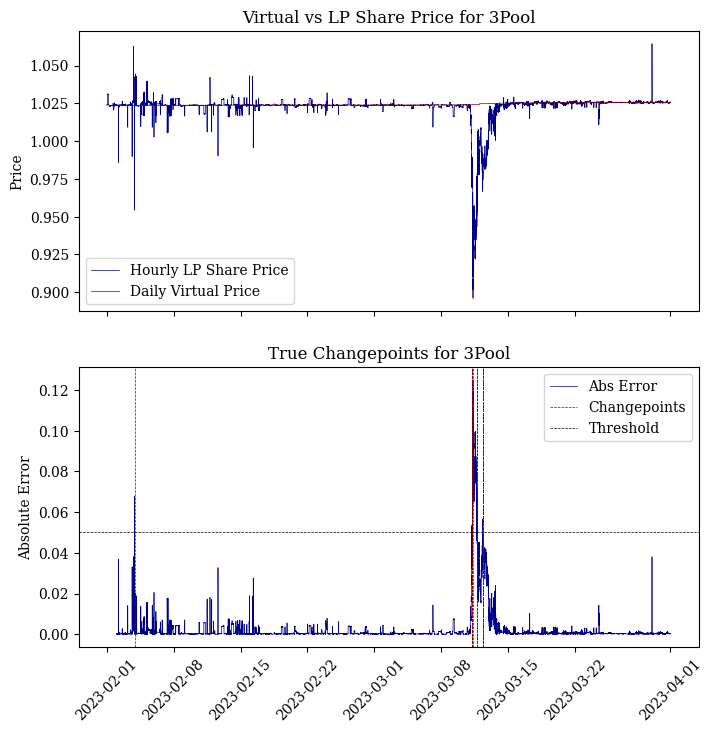

In [22]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

axs[0].plot(rp.index, rp, color='darkblue', linewidth=0.5, label='Hourly LP Share Price')  
axs[0].plot(vp.index, vp, color='darkred', linewidth=0.5, label='Daily Virtual Price')
axs[0].set_title('Virtual vs LP Share Price for 3Pool')
axs[0].legend()
axs[0].set_ylabel('Price')

axs[1].plot(error.index, error, color='darkblue', linewidth=0.5, label='Abs Error')

for cp in cps:
    axs[1].axvline(cp, linestyle='--', linewidth=0.5, color='darkred')
if len(cps):
    axs[1].plot([], [], label='Changepoints', color='darkred', linestyle='--', linewidth=0.5)
    
axs[1].axhline(0.05, linestyle='--', linewidth=0.5, color='black', label='Threshold')
axs[1].legend()
axs[1].tick_params(axis='x', rotation=45)
axs[1].set_title('True Changepoints for 3Pool')
axs[1].set_ylabel('Absolute Error')

f.savefig('../figs/3crv_cps', bbox_inches='tight')

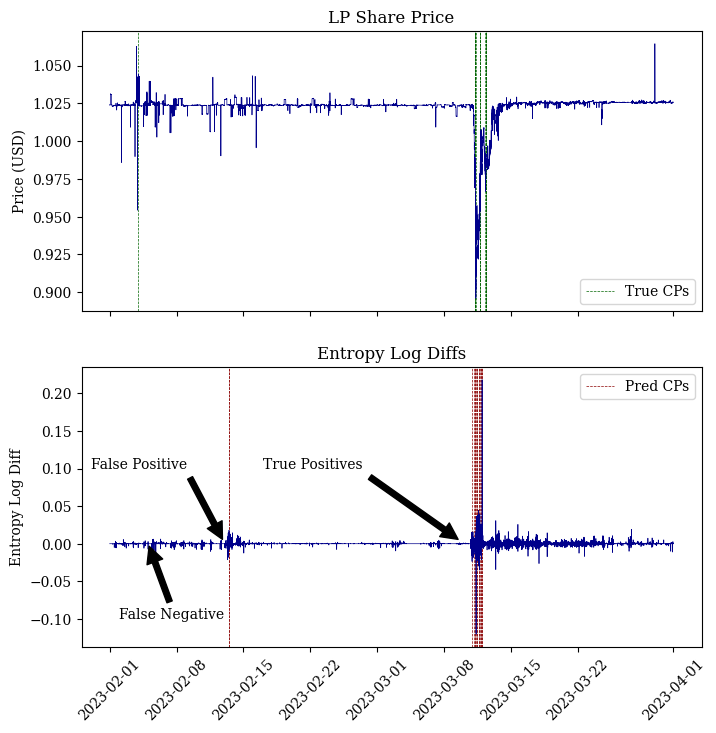

In [23]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

freq = '1min'

metric = np.log1p(pool_metrics['shannonsEntropy'].pct_change()).resample(freq).mean()
port = lp_share_price.resample(freq).mean()

if len(cps):
    for cp in cps:
        axs[0].axvline(cp, linestyle='--', linewidth=0.5, color='darkgreen')
    axs[0].plot([], [], label='True CPs', color='darkgreen', linestyle='--', linewidth=0.5)

axs[0].plot(port.index, port, linewidth=0.5, c='darkblue')
axs[0].set_title('LP Share Price')
axs[0].set_ylabel('Price (USD)')
axs[0].legend()

if len(peaks):
    for peak in peaks[:-1]:
        axs[1].axvline(metric.index[peak*60], linestyle='--', color='darkred', linewidth=0.5)
    axs[1].plot([], [], color='darkred', linestyle='--', linewidth=0.5, label='Pred CPs')

axs[1].legend()

axs[1].plot(metric.index, metric, linewidth=0.5, c='darkblue')
axs[1].set_title('Entropy Log Diffs')
axs[1].set_ylabel('Entropy Log Diff')

axs[1].annotate('False Negative', xy=(19393, 0.001), xytext=(19390, -0.1),
            arrowprops=dict(facecolor='black', shrink=0.05))

axs[1].annotate('True Positives', xy=(19426, 0.001), xytext=(19405, 0.1),
            arrowprops=dict(facecolor='black', shrink=0.05))

axs[1].annotate('False Positive', xy=(19401, 0.001), xytext=(19387, 0.1),
            arrowprops=dict(facecolor='black', shrink=0.05))

axs[1].tick_params(axis='x', rotation=45)

f.savefig('../figs/lp_cps_3crv.png', bbox_inches='tight')
plt.show()

# Scoring

In [24]:
minpeaks = metric.index[peaks*60]
f_measure({1:cps}, minpeaks, return_PR=True)

(0.5454545454545455, 0.5294117647058824, 0.5625)

# Grid Search

In [19]:
alpha = [0.01, 0.1, 1, 10, 100, 1000, 10000]
beta = [0.0001, 0.001, 0.01, 0.1, 1, 10]
kappa = [0.0001, 0.001, 0.01, 0.1, 1, 10]

grid = [[a, b, k] for a in alpha for b in beta for k in kappa]

In [62]:
%%time
freq = '1h'
metric = np.log1p(pool_metrics['shannonsEntropy'].pct_change()).resample(freq).mean()

count = 0
total = len(grid)

results = {}
for a, b, k in grid:
    R, maxes = bocd(metric[:-1], alpha=a, beta=b, kappa=k)
    peaks = np.where(maxes[:-1]!=maxes[1:]-1)[0][:-1]
    if not len(peaks):
        count += 1
        continue
    minpeaks = metric.index[peaks]
    results[(a, b, k)] = f_measure({1:cps}, minpeaks, margin=timedelta(hours=24), alpha=1/5, return_PR=True)

    count += 1
    progress = round(count/total, 2) * 100
    if progress % 10 == 0:
        print(f'{progress}% done ', end='')

0.0% done 3000.0% done 3000.0% done 6000.0% done 

/root/curve-lp-metrics/venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6703: RuntimeWarning: overflow encountered in power
  / (np.sqrt(df*np.pi)*(1+(x**2)/df)**((df+1)/2))
/root/curve-lp-metrics/venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6703: RuntimeWarning: overflow encountered in multiply
  / (np.sqrt(df*np.pi)*(1+(x**2)/df)**((df+1)/2))
/root/curve-lp-metrics/venv/lib/python3.10/site-packages/bayesian_changepoint_detection/bayesian_models.py:129: RuntimeWarning: invalid value encountered in divide
  R[:, t + 1] = R[:, t + 1] / np.sum(R[:, t + 1])


9000.0% done 9000.0% done 9000.0% done CPU times: user 3min 3s, sys: 43.6 ms, total: 3min 3s
Wall time: 3min 3s


(0.5648665425201738, 0.2545454545454545, 0.8125)


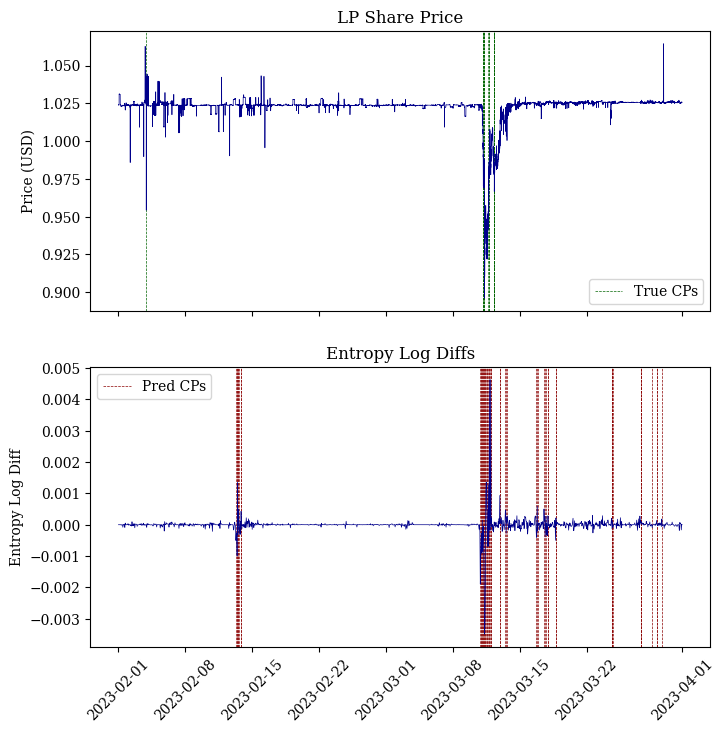

In [63]:
a, b, k = max(results, key=lambda x: results[x][2])
print(results[(a, b, k)])
R, maxes = bocd(metric[:-1], alpha=a, beta=b, kappa=k)
peaks = np.where(maxes[:-1]!=maxes[1:]-1)[0][:-1]
bocd_plot_comp(metric, port, cps, peaks)

(0.1515151515151515, 1.0, 0.125)


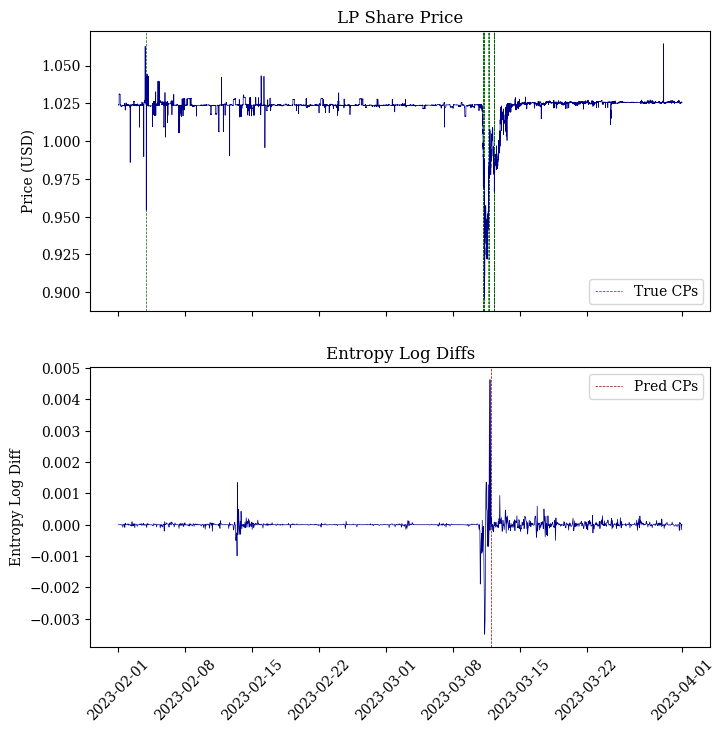

In [64]:
a, b, k = max(results, key=lambda x: results[x][1])
print(results[(a, b, k)])
R, maxes = bocd(metric[:-1], alpha=a, beta=b, kappa=k)
peaks = np.where(maxes[:-1]!=maxes[1:]-1)[0][:-1]
bocd_plot_comp(metric, port, cps, peaks)

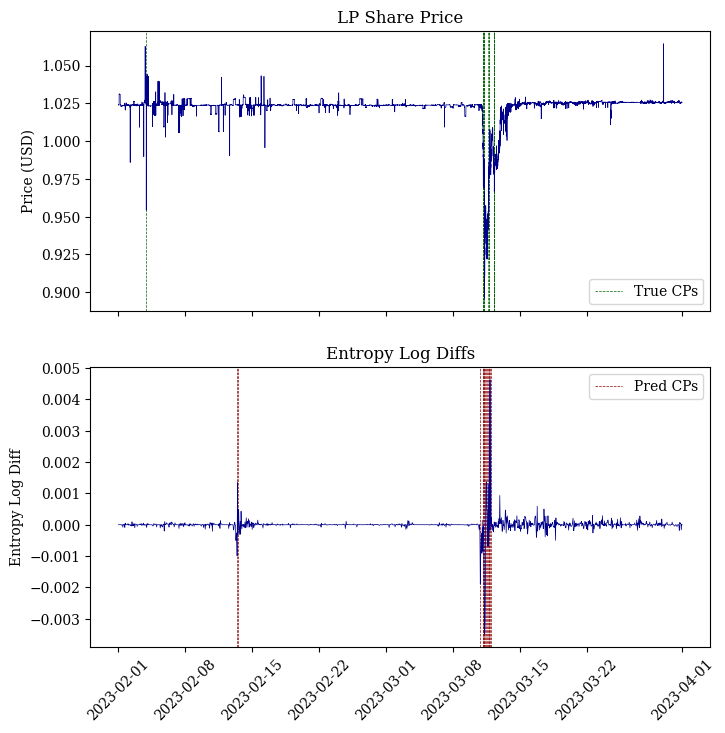

In [65]:
a, b, k = max(results, key=lambda x: results[x][0])
R, maxes = bocd(metric[:-1], alpha=a, beta=b, kappa=k)
peaks = np.where(maxes[:-1]!=maxes[1:]-1)[0][:-1]
bocd_plot_comp(metric, port, cps, peaks)